In [276]:
import numpy as np, pandas as pd
from ISLP import load_data
import seaborn as sns
from matplotlib import pyplot as plt
import ISLP
from ISLP import load_data
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError ,
    R2Score)
from sklearn.metrics import f1_score
from torchinfo import summary
from torchvision.io import read_image
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
import pytorch_lightning as L
from pytorch_lightning.loggers import CSVLogger
from torchvision.datasets import MNIST , CIFAR100
from IPython.display import clear_output
from torchvision.models import (resnet50 ,
    ResNet50_Weights)
from torchvision.transforms import (Resize ,
    Normalize ,
    CenterCrop ,
    ToTensor)
from ISLP.torch import (SimpleDataModule ,
    SimpleModule ,
    ErrorTracker ,
    rec_num_workers)
from ISLP.torch.imdb import (load_lookup ,
    load_tensor ,
    load_sparse ,
    load_sequential)
from glob import glob
import json
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from ISLP.models import sklearn_sm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import ISLP
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import SplineTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_diabetes
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
import seaborn as sns
import itertools
from ISLP import bart
from ISLP.svm import plot as plot_svm
from pygam import LinearGAM, s, f, l
sns.set_palette("pastel")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [277]:
def reorder_columns_rnn(X, lag_nb, non_lag_cols, lag_cols):
    for col in non_lag_cols:
        for i in range(1,lag_nb+1):
            X[f'{col}_{i}'] = X[col]
    
    ordered_cols = []
    
    for lag in range (lag_nb,0,-1):
        for col in lag_cols+non_lag_cols:
            ordered_cols.append('{0}_{1}'.format(col , lag))
    return X.reindex(columns=ordered_cols)

In [278]:
lag_nb = 5

NYSE = load_data('NYSE').dropna().reset_index()
NYSE['month'] = NYSE['date'].apply(lambda x : int(x.split('-')[1]))
X = pd.get_dummies(NYSE, columns=['month', 'day_of_week'], drop_first=True)
X = pd.concat((X, X[['DJ_return', 'log_volume', 'log_volatility']].shift(periods=range(1,lag_nb+1))), axis=1)
X = X.dropna()
y = X['log_volume']
X = X.drop(columns=['date', 'DJ_return', 'log_volume', 'log_volatility'])

lag_cols = ['DJ_return', 'log_volume', 'log_volatility']
non_lag_cols = [col for col in X.columns if 'day' in col or 'month' in col]
train_index = X[X['train'] == True].index
test_index = X[X['train'] == False].index
X = reorder_columns_rnn(X, lag_nb, non_lag_cols, lag_cols)

In [279]:
X_train = X.loc[train_index]
X_test =X.loc[test_index]
y_train = y[train_index]
y_test = y[test_index]
to_scale_col = X_train.select_dtypes(np.float64).columns
scaler = StandardScaler().fit(X_train[to_scale_col])
X_train[to_scale_col] = scaler.transform(X_train[to_scale_col])
X_test[to_scale_col] = scaler.transform(X_test[to_scale_col])

In [280]:
X_val = X_test.loc[4281:5000]
y_val = y_test.loc[4281:5000]

In [281]:
X_train_rnn = X_train.to_numpy().reshape((-1,5,18))
X_test_rnn = X_test.to_numpy().reshape((-1,5,18))
X_val_rnn = X_val.to_numpy().reshape((-1,5,18))

X_train_t = torch.tensor(X_train_rnn.astype(np.float32))
y_train_t = torch.tensor(y_train.to_numpy().astype(np.float32))
def_train = TensorDataset(X_train_t , y_train_t)

X_test_t = torch.tensor(X_test_rnn.astype(np.float32))
y_test_t = torch.tensor(y_test.to_numpy().astype(np.float32))
def_test = TensorDataset(X_test_t , y_test_t)

X_val_t = torch.tensor(X_val_rnn.astype(np.float32))
y_val_t = torch.tensor(y_val.to_numpy().astype(np.float32))
def_val = TensorDataset(X_val_t , y_val_t)

train_dataloader = DataLoader(def_train, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(def_test, batch_size=128, shuffle=False, pin_memory=True)
val_dataloader = DataLoader(def_val, batch_size=128, shuffle=False, pin_memory=True)

In [307]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel , self).__init__ ()
        self.rnn = nn.RNN(18,
            30,
            num_layers=3,
            nonlinearity='relu',
            batch_first=True)
        self.dense = nn.Linear(30, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self , x):
        val , h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1]))
        return torch.flatten(val)

class linear_NYSEModel(nn.Module):
    def __init__(self):
        super(linear_NYSEModel , self).__init__ ()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(30, 1)
    def forward(self , x):
        flat_x = self.flatten(x)
        val = self.dense(flat_x)
        return val

class Non_linear_NYSEModel(nn.Module):
    def __init__(self):
        super(Non_linear_NYSEModel , self).__init__ ()
        self.seq = nn.Sequential(
            nn.Flatten(),
            nn.Linear(30, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(50, 30),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(30, 1))
        
    def forward(self , x):
        val = self.seq(x)
        return val

In [308]:
summary(Non_linear_NYSEModel() ,
    input_data=X_train_t ,
    col_names =['input_size',
    'output_size',
    'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Non_linear_NYSEModel                     [4276, 30]                [4276, 1]                 --
├─Sequential: 1-1                        [4276, 30]                [4276, 1]                 --
│    └─Flatten: 2-1                      [4276, 30]                [4276, 30]                --
│    └─Linear: 2-2                       [4276, 30]                [4276, 100]               3,100
│    └─ReLU: 2-3                         [4276, 100]               [4276, 100]               --
│    └─Dropout: 2-4                      [4276, 100]               [4276, 100]               --
│    └─Linear: 2-5                       [4276, 100]               [4276, 50]                5,050
│    └─ReLU: 2-6                         [4276, 50]                [4276, 50]                --
│    └─Dropout: 2-7                      [4276, 50]                [4276, 50]                --
│    └─Linear: 2-8           

In [284]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < (self.min_validation_loss - self.min_delta):
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [285]:
class NN_Trainer:
    def __init__(self, train_dl, val_dl, model, loss_fn, optimizer, max_epoch, early_stop):
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.train_loss_array = []
        self.val_loss_array = []
        self.early_stop = early_stop
        
    def train(self):
        for epoch in range(1, self.max_epoch+1):
            self.model.train()
            epoch_loss = 0
            for batch, (X, y) in enumerate(self.train_dl):
                X,y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
                # Compute prediction error
                pred = self.model(X)
                train_loss = self.loss_fn(pred, y)
                epoch_loss += train_loss.item()
        
                # Backpropagation
                train_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                
            epoch_loss = epoch_loss/len(self.train_dl)
            val_loss = self.validation()
            self.train_loss_array.append(epoch_loss)
            self.val_loss_array.append(val_loss)
            
            if epoch > 30 and self.early_stop.early_stop(val_loss):             
                break
                
            if epoch%10 == 0:
                clear_output(wait=True)
                print(f"{epoch}/{self.max_epoch+1}")
                print(f"Train loss: {epoch_loss:>7f}")
                print(f"Val loss: {val_loss:>7f}")
        self.model.eval()

    def validation(self):
        self.model.eval()
        with torch.no_grad():
            val_loss = 0
            for X, y in self.val_dl:
                X,y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
                pred = self.model(X)
                val_loss += self.loss_fn(pred, y).item()
        return val_loss/len(self.val_dl)

In [ ]:
nyse_model = NYSEModel()
nyse_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(nyse_model.parameters(), lr=1e-3)
early_stopper = EarlyStopper(patience=50, min_delta=0)
max_epoch = 10000
trainer = NN_Trainer(train_dataloader, val_dataloader, nyse_model, loss_fn, optimizer, max_epoch, early_stopper)
trainer.train()

<Axes: >

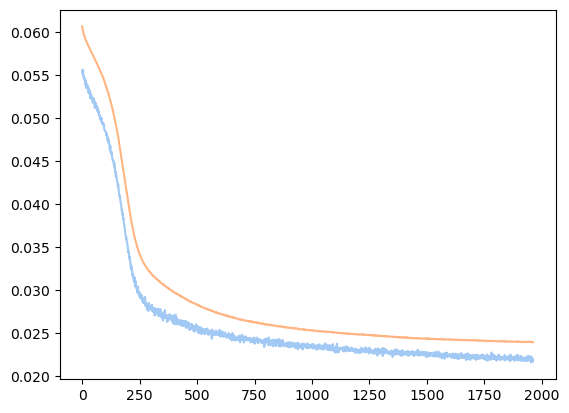

In [155]:
sns.lineplot(trainer.train_loss_array[1:])
sns.lineplot(trainer.val_loss_array[1:])

In [159]:
y_pred_rnn = nyse_model(X_test_t.to(device)).cpu().detach().numpy()
r2_score(y_test,y_pred_rnn), mean_squared_error(y_test,y_pred_rnn)

(0.44499797051271406, 0.03192962313894129)

In [287]:
import re
pattern = re.compile(".*_1$")
to_keep = [ x for x in X_train.columns if ('month' not in x and 'week' not in x) or (pattern.match(x)) ]
X_train = X_train[to_keep]
X_test = X_test[to_keep]
X_val = X_val[to_keep]

y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)
y_val = y_val.to_numpy().reshape(-1,1)


X_train_rnn = X_train.to_numpy()
X_test_rnn = X_test.to_numpy()
X_val_rnn = X_val.to_numpy()

X_train_t = torch.tensor(X_train_rnn.astype(np.float32))
y_train_t = torch.tensor(y_train.astype(np.float32))
def_train = TensorDataset(X_train_t , y_train_t)

X_test_t = torch.tensor(X_test_rnn.astype(np.float32))
y_test_t = torch.tensor(y_test.astype(np.float32))
def_test = TensorDataset(X_test_t , y_test_t)

X_val_t = torch.tensor(X_val_rnn.astype(np.float32))
y_val_t = torch.tensor(y_val.astype(np.float32))
def_val = TensorDataset(X_val_t , y_val_t)

train_dataloader = DataLoader(def_train, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(def_test, batch_size=128, shuffle=False, pin_memory=True)
val_dataloader = DataLoader(def_val, batch_size=128, shuffle=False, pin_memory=True)

In [ ]:
nyse_model = linear_NYSEModel()
nyse_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(nyse_model.parameters(), lr=1e-3)
early_stopper = EarlyStopper(patience=50, min_delta=0.00001)
max_epoch = 10000
trainer = NN_Trainer(train_dataloader, val_dataloader, nyse_model, loss_fn, optimizer, max_epoch, early_stopper)
trainer.train()

<Axes: >

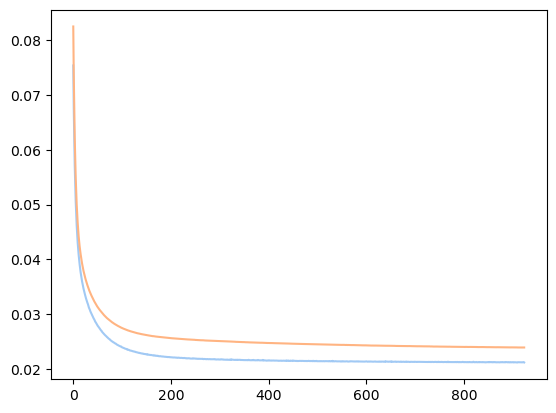

In [290]:
sns.lineplot(trainer.train_loss_array[1:])
sns.lineplot(trainer.val_loss_array[1:])

In [291]:
y_pred_rnn = nyse_model(X_test_t.to(device)).cpu().detach().numpy()
r2_score(y_test,y_pred_rnn), mean_squared_error(y_test,y_pred_rnn)

(0.46003696275963135, 0.031064420258012856)

In [309]:
nyse_model = Non_linear_NYSEModel()
nyse_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(nyse_model.parameters(), lr=1e-3)
early_stopper = EarlyStopper(patience=50, min_delta=0.00001)
max_epoch = 10000
trainer = NN_Trainer(train_dataloader, val_dataloader, nyse_model, loss_fn, optimizer, max_epoch, early_stopper)
trainer.train()

2510/10001
Train loss: 0.026537
Val loss: 0.025841


<Axes: >

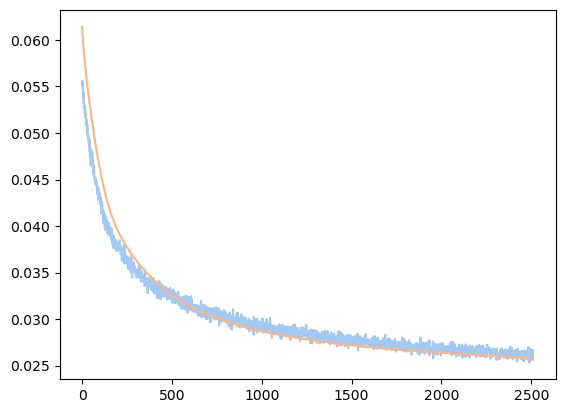

In [310]:
sns.lineplot(trainer.train_loss_array[1:])
sns.lineplot(trainer.val_loss_array[1:])

In [311]:
y_pred_rnn = nyse_model(X_test_t.to(device)).cpu().detach().numpy()
r2_score(y_test,y_pred_rnn), mean_squared_error(y_test,y_pred_rnn)

(0.4227686904579927, 0.033208487894540346)